# Predicting the salary of National Hockey League players

## Intro and game plan

### Credit 
When I originally encountered this amazingly detailed dataset (http://www.hockeyabstract.com/testimonials/nhl2016-17playerdata) on Rob Vollman's hockey analytics website I thought it presented an excellent source of information for trying to build predictive models based on the large number of on and off ice metrics provided. For this initial model run I am limiting myself to the 2016/2017 season (so as to avoid pseudoreplication by using multiple years of data where the same players are present in multiple year's data). 

### Salary and its influences
I've chosen to use salary as the response variable for this analysis as I think it is likely influenced by a large number of factors (even extending beyond a player's on ice performance). For those of you unfamiliar with the NHL, the league has a salary cap, meaning that each team is limited in the amount of money it can spend on players. Notably, the dollar figure that counts toward the salary cap isn't the actual amount of money a player makes in a season, it is the average of their yearly compensation over the length of their contract. For example, Sidney Crosby's 'cap hit' for his team is \$8.7 million dollars, but he in fact made \$10.9 million last year (https://www.capfriendly.com/players/sidney-crosby). This front loading of long contracts means that as star players age their salary goes down dramatically. Similarly young players with amaizing productivity on ice may be paid relatively little because they are limited to the size of a contract they can sign immediately after they are drafted. The Toronto Maple Leafs best player is 19, and he makes under \$1 million a year (https://www.capfriendly.com/players/auston-matthews).


### What we will do

In order to build a model of the factors influencing NHL salary, I will first need to clean the dataset, imputing missing values and removing categorical columns that could lead to overfit. With that done I will explore and visualize some of the relationships in the data before finally building a random forest model and interating until we find the most optimal set of predictive features.


# 1. Load the data and libraries we will need



In [1]:
#libraries we will be using
library('randomForest')
library('plyr')
library('stringr')
library('tidyverse')
library("magrittr")
library("scatterplot3d")

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.
Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
arrange():   dplyr, plyr
combine():   dplyr, randomForest
compact():   purrr, plyr
count():     dplyr, plyr
failwith():  dplyr, plyr
filter():    dplyr, stats
id():        dplyr, plyr
lag():       dplyr, stats
margin():    ggplot2, randomForest
mutate():    dplyr, plyr
rename():    dplyr, plyr
summarise(): dplyr, plyr
summarize(): dplyr, plyr

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract



In [2]:
train = read.csv('./hockey_dat/train.csv')
head(train)
test_x = read.csv('./hockey_dat/test.csv')
head(test_x)
test_y = read.csv('./hockey_dat/test_salaries.csv')
head(test_y)


Salary,Born,City,Pr.St,Cntry,Nat,Ht,Wt,DftYr,DftRd,⋯,PEND,OPS,DPS,PS,OTOI,Grit,DAP,Pace,GS,GS.G
925000,97-01-30,Sainte-Marie,QC,CAN,CAN,74,190,2015,1,⋯,1,0.0,-0.2,-0.2,40.03,1,0.0,175.7,-0.4,-0.38
2250000,93-12-21,Ottawa,ON,CAN,CAN,74,207,2012,1,⋯,98,-0.2,3.4,3.2,2850.59,290,13.3,112.5,14.1,0.18
8000000,88-04-16,St. Paul,MN,USA,USA,72,218,2006,1,⋯,70,3.7,1.3,5.0,2486.75,102,6.6,114.8,36.8,0.57
3500000,92-01-07,Ottawa,ON,CAN,CAN,77,220,2010,1,⋯,22,0.0,0.4,0.5,1074.41,130,17.5,105.1,5.9,0.20
1750000,94-03-29,Toronto,ON,CAN,CAN,76,217,2012,1,⋯,68,-0.1,1.4,1.3,3459.09,425,8.3,99.5,21.8,0.27
1500000,79-05-23,Strathroy,ON,CAN,CAN,70,192,1997,6,⋯,60,0.6,3.7,4.3,3069.81,150,4.5,107.4,20.8,0.26


Born,City,Pr.St,Cntry,Nat,Ht,Wt,DftYr,DftRd,Ovrl,⋯,PEND,OPS,DPS,PS,OTOI,Grit,DAP,Pace,GS,GS.G
88-11-05,Ithaca,NY,USA,USA,72,216,2003,1,13,⋯,65,1.9,1.8,3.7,3418.06,243,19.5,110.4,47.3,0.59
00-02-29,Prague,,CZE,CZE,72,195,2014,1,13,⋯,10,0.3,0.3,0.6,826.49,15,10.0,118.6,8.9,0.42
92-04-24,St. Louis,MO,USA,USA,75,227,2007,6,161,⋯,86,3.9,2.0,6.0,3155.13,316,8.9,115.0,52.5,0.65
99-07-05,Piikkio,,FIN,FIN,72,182,2013,2,55,⋯,40,2.3,1.1,3.4,3044.03,105,24.3,111.9,38.1,0.52
96-10-27,Niagara Falls,NY,USA,USA,72,196,2011,2,36,⋯,25,0.8,1.1,1.9,1217.17,67,4.8,105.4,15.9,0.51
87-01-11,Bloomington,MN,USA,USA,74,210,2002,4,129,⋯,11,0.3,0.5,0.8,756.76,44,3.7,104.5,5.9,0.33


Salary
7000000
925000
2000000
667500
600000
1400000


# 2. Clean the data

We need to impute missing data and fix problem categorical columns to do this we merge the train and test data into a single set First, where are there missing values?

In [3]:
#add train/test column
test_x$TrainTest = "test"
train$TrainTest =  "train"

test = cbind(test_y, test_x)
all_data = rbind(train,test)

In [4]:
#where are there missing values?
all_missing_list=  colnames(all_data)[colSums(is.na(all_data)) > 0]
all_missing_list

[1] "DftYr"   "DftRd"   "Ovrl"    "TOIX"    "TOI."    "IPP."    "SH."    
 [8] "SV."     "PDO"     "F.60"    "A.60"    "Diff.60" "iCF"     "iFF"    
[15] "iSF"     "ixG"     "iSCF"    "iRB"     "iRS"     "iDS"     "sDist.1"
[22] "Pass"    "iHF.1"   "iHA"     "iHDf"    "iGVA.1"  "iTKA.1"  "iBLK.1" 
[29] "BLK."    "iFOW.1"  "iFOL.1"  "X.FOT"   "iPENT"   "iPEND"   "CF"     
[36] "CA"      "FF"      "FA"      "SF"      "SA"      "xGF"     "xGA"    
[43] "SCF"     "SCA"     "GF"      "GA"      "RBF"     "RBA"     "RSF"    
[50] "RSA"     "FOW"     "FOL"     "HF"      "HA"      "GVA"     "TKA"    
[57] "PENT"    "PEND"    "OTOI"    "Pace"    "GS"      "GS.G"

### 2.a Impute state column for international players

Pr.St tells you which Canadian province or American state the player was born in. I am going to impute 'INT' to designate international for all the other individuals (as I don't have time to examine the regional political structures of multiple nations).

In [5]:
#fill the Pr.St column with 'INT' for international players
all_data$Pr.St = mapvalues(all_data$Pr.St, from = "", to="INT")

### 2.b Team column

Some players have multiple teams they played for. We will split each time into its own boolean predictor and those who player for multiple teams are recorded accordingly. 

In [6]:

#Make team boolean columns
#get the unique list of team acronymns
teams = c()
for( i in levels(all_data$Team)){
	x = strsplit(i, "/")
	for(y in x){
		teams = c(teams, y)
	}
}
teams = unique(teams)

# add columns with the team names as the header and 0 as values
for(team in teams){
	all_data[,team] = 0
}

#iterate through and record the teams for each player
for(i in 1:length(all_data$Team)){
	teams_of_person = strsplit(as.character(all_data$Team[i]), "/")[[1]]
	for(x in teams_of_person){
		all_data[,x][i] = 1	
	}
}


### 2.c Positions played

Splitting of the categorical position column into multiple booleans. Most players have a single position such as "D" (defence) for those with multiple positions, we will record this fact.

In [7]:

#4e Make position boolean columns
pos = c()
for( i in levels(all_data$Position)){
	x = strsplit(i, "/")
	for(y in x){
		pos = c(pos, y)
	}
}
pos = unique(pos)

# add columns with the pos names as the header and 0 as values
for(position in pos){
	all_data[,position] = 0
}

#iterate through and record the position(s) for each player
for(i in 1:length(all_data$Position)){
	pos_of_person = strsplit(as.character(all_data$Position[i]), "/")[[1]]
	for(x in pos_of_person){
		all_data[,x][i] = 1	
	}
}




### 2.d Year, day and month of birth

We need to manipulate the date of birth into three columns: year of birth, month of birth, and day of birth. There is special care givent to the year column to account for players born after the year 2000. Some of you may find it odd that I am giving day and month their own predictors. It is an often quoted fact in Canada that the month of someone's birth affects their chances of making the NHL, the logic being that if you are born early in the year then as a child you are several months older than some of the other kids in your age class and this gives you a development advantage. I don't know if this is true but we will include the data to check if it is contributing to the final random forest model!

In [8]:
#turn the born column into 
# an age column 
# 3 integer columns year:month:date

bday_parts = str_split_fixed(all_data$Born, "-", 3)

#adjust year column to account for missing digits
birth_year = c()
for(year in bday_parts[,1]){
	if(as.numeric(year) < 10){
		yr = paste("20", year, sep="")
		birth_year = c(birth_year, yr)
	}else{
		yr = paste("19",year, sep="")
		birth_year = c(birth_year, yr)
	}
}

all_data$birth_year = as.numeric(birth_year)
all_data$birth_month = as.numeric(bday_parts[,2])
all_data$birth_day = as.numeric(bday_parts[,3])


### 2.e Citizenship and country of birth

These may appear redundant, but there are some players that citizenship does not match the country they were born in. I am therefore including both in the final model and feature selection will hopefully let us remove redundancy.

In [9]:
#4gDONE split Cntry and Nat to boolean columns

birth_country = levels(all_data$Cntry)
# add columns with the country of birth options
# note the Estonia for Uncle Leo
for(country in birth_country){
	c = paste("born", country, sep="_")

	all_data[,c] = 0
}

#iterate through and record the birth country of each player
for(i in 1:length(all_data$Cntry)){
	birth_country = all_data$Cntry[i]
	c = paste("born", birth_country, sep="_")
	all_data[,c][i] = 1	
}


nationality = levels(all_data$Nat)
for(country in nationality){
	c = paste("nation", country, sep="_")
	all_data[,c] = 0
}

#iterate through and record the birth country of each player
for(i in 1:length(all_data$Nat)){
	nationality = all_data$Nat[i]
	c = paste("nation", nationality, sep="_")
	all_data[,c][i] = 1	
}


### 2.f Impute numerical columns

Finally we impute the missing value's median for numerical columns. First for the numerical column draft year, we account for undrafted players by creating a boolean column (and imputing the median draft year which is unfortunately necessary).

In [10]:
all_data$undrafted = is.na(all_data$DftRd)

#fill median values
#loop through the dataframe, filling each column with the median of 
#the existing values for the entire dataset
#where are there still missing values?

all_missing_list =  colnames(all_data)[colSums(is.na(all_data)) > 0]
length(all_missing_list) == 0
#if above true all values are imputed!

for( i in 1:length(all_missing_list)){
	#get the global median
	median_all = median(all_data[,all_missing_list[i]], na.rm =TRUE)
	#imput the missing values with the column's median
	all_data[,all_missing_list[i]][is.na(all_data[,all_missing_list[i]])] = median_all
}

length(all_missing_list) == 0

[1] FALSE

[1] FALSE

## 3. Graphical analyses & data exploration

Now that we have curated the data we can begin to explore some of the relationships and trends that exist prior to building our model.

### 3.a how many players from each country?

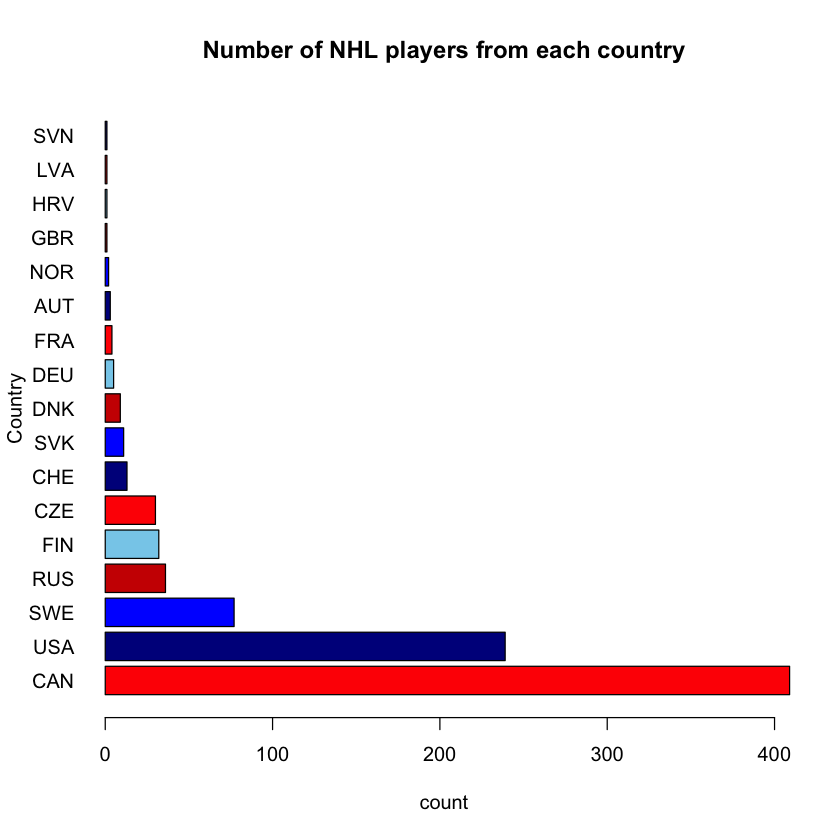

In [11]:
barplot(sort(table(all_data$Nat),decreasing=TRUE), horiz=TRUE, las=1,col=c("red","blue4","blue","red3","skyblue"),main="Number of NHL players from each country", ylab="Country",xlab="count")

As we can see from the above graph a large portion of players are still Canadian. There is a suprisignly high number of American players in the league as well!
I also learned a fun fact from researching the above graph HRV is the short form for Croatia suprisingly enough, and that single Croatian NHL player is Borna Rendulić who playeed a single game for the Vancouver Canucks last season.

### 3.b Age breakdown

In [12]:
table(all_data$birth_year)


1972 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 
   1    2    2    6   11   12    9   21   22   27   29   43   44   59   63   59 
1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 
  77   71   77   74   51   50   34   15   11    4 

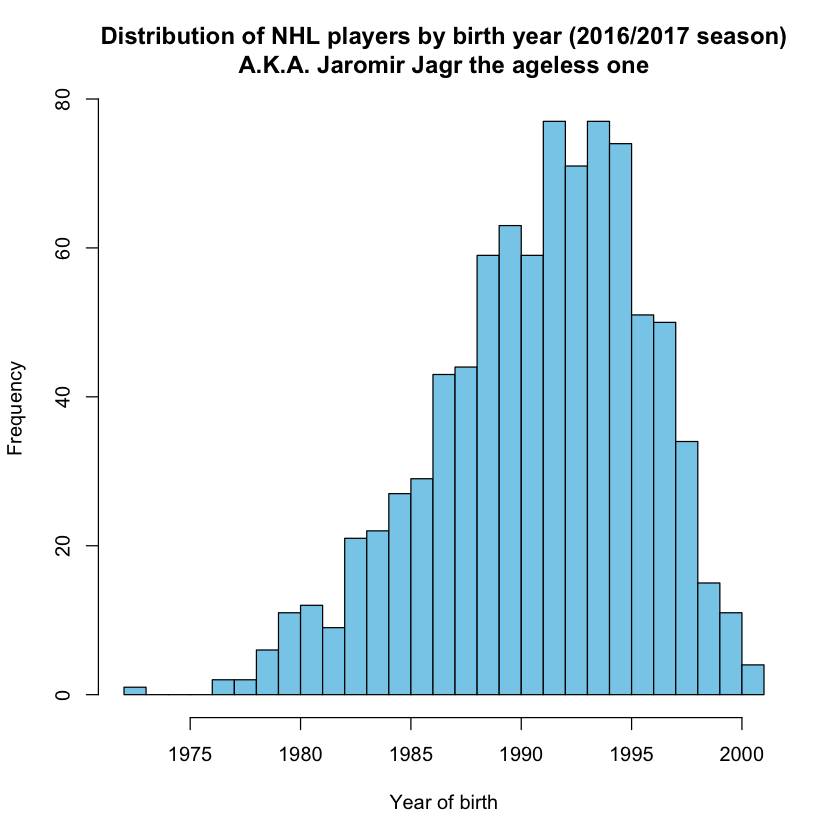

In [13]:
hist(all_data$birth_year, breaks=28, col="skyblue", xlab='Year of birth', main='Distribution of NHL players by birth year (2016/2017 season)\nA.K.A. Jaromir Jagr the ageless one')

Behold the beautiful outlier that is Jaromir Jagr, born five years before the next two oldest players in the legaue. (Tangent: Can you name the 2nd and 3rd oldest players?) Jagr aside, there is some left skew to the plot, father time comes for us all but some players seem better at delaying the effects!

Note there are 15 nhl players born in 2000 or later... this makes me feel old!

### 3.c. Distribution of NHL salaries

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
  575000   742500   925000  2325000  3700000 14000000 

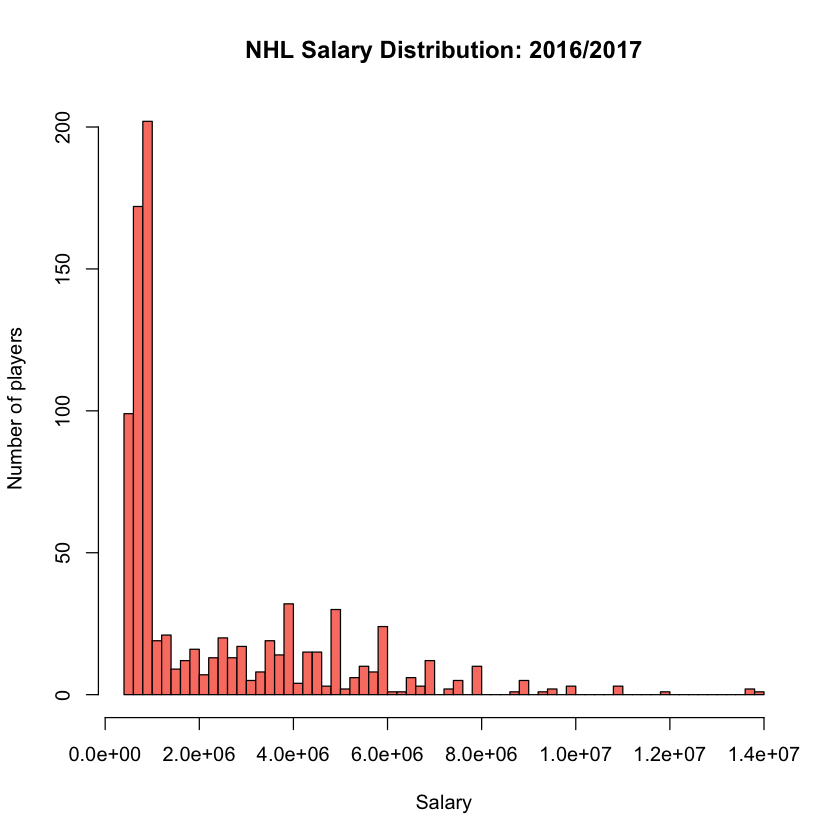

In [14]:
summary(all_data$Salary)
hist(all_data$Salary, breaks=52, col="salmon", xlab='Salary', ylab = "Number of players", main='NHL Salary Distribution: 2016/2017')

Talk about income disparity. The median NHL player is making \$925,000 which is a pretty good paycheck, but the maximium is $14,000,000. That is some extreme right skew.

### 3.d. Comparing salary to on ice performance

There is definitely more to being a good hockey player than just goals, but this is a classic metric and one that we can use as a starting point to understand the interplay between multiple on ice statistics and the amount that players are compensated.

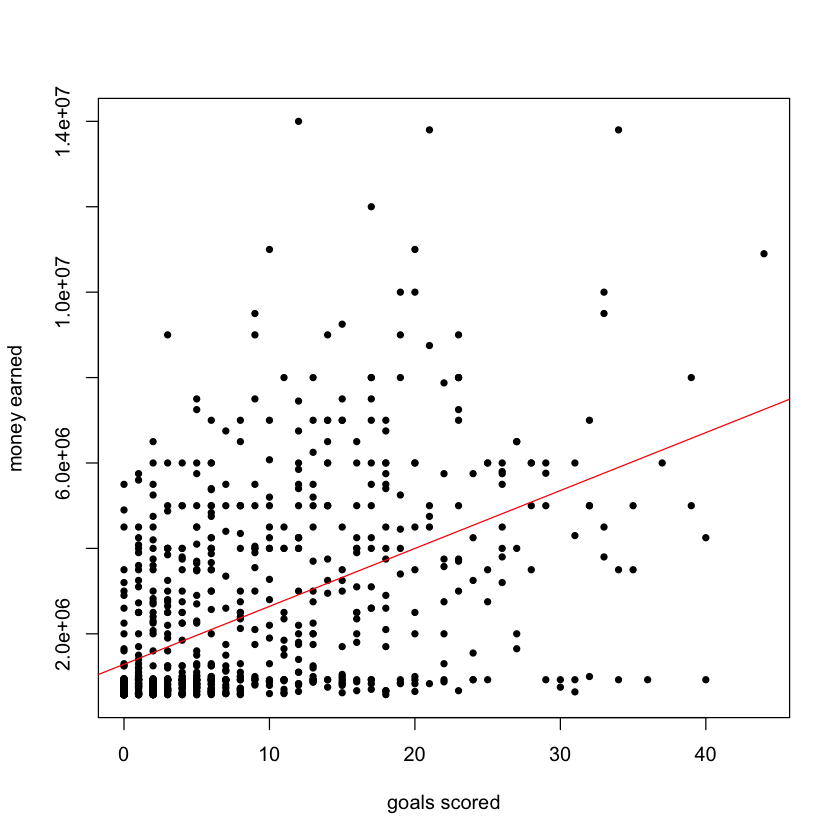

In [15]:
plot(all_data$G, all_data$Salary, xlab='goals scored',pch=20 , ylab='money earned')
abline(lm(all_data$Salary ~ all_data$G), col="red")

A large amount of variation here, if we label the points then maybe it will be possible to draw some further insights from this scatterplot.

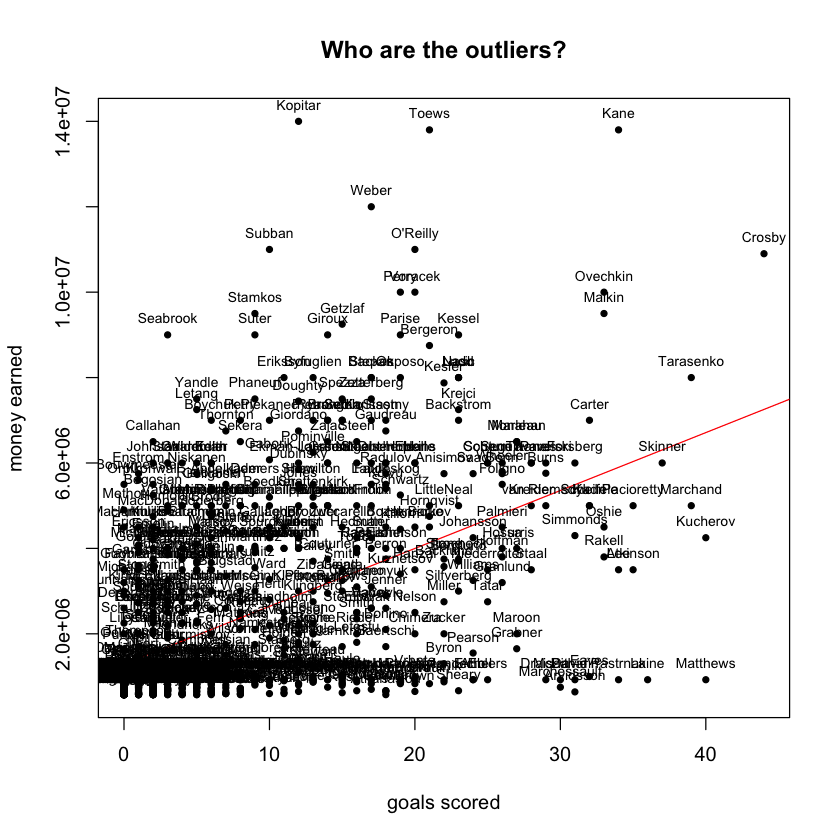

In [16]:
plot(all_data$G, all_data$Salary, pch=20, xlab='goals scored', ylab='money earned', main="Who are the outliers?")
abline(lm(all_data$Salary ~ all_data$G), col="red")
text(all_data$G, all_data$Salary, labels=all_data$Last.Name, cex=0.7, pos = 3)

The high paid, high scoring franchise players cluster to the top right, but the real value is hiddeni in the bottom right. We see Auston Matthews and Patrick Laine (name slightly covered); these were the first and second overall picks in the previous year's entry draft. One could argue that they provide the most cost effective scoring in the league. This highlights the value of the entry draft in the salary cap era, it provides high quality players at rock bottom prices! 

There are clearly multiple factors that are affecting how much a player makes, and things like rookie contracts cause strong disconnects between on ice metrics of success (such as goals, corsi, +/-, time on ice, etc.) and other considerations such as the players age.

#### Come with me on a tangent!
How much was Auston Matthews paid per goal, how about Sidney Crosby?

In [17]:
matthews_goal_price =925000/40
print(paste("Auston matthews makes only $" ,matthews_goal_price, "a goal... what a deal!"))
crosby_goal_price = 10900000/44
#Crosby was paid $247,727  a goal. 
print(paste("Crosby was paid $" ,crosby_goal_price, "a goal."))
print("The median house price in Pittsburgh is $123,500") #source is us census for this next bit
print("So Sid could by two Pittsburgh houses for every goal he scores.")
Crosby_homes = 8.7*12 #twelve year contract
pittsburgh_households = 143739 #us census
Crosby_market_share = (Crosby_homes/pittsburgh_households)*100
print(paste("So over his current 12 year contract he could buy up",Crosby_market_share, "% of the total pittsburgh housing market (before taxes of course)."))


[1] "Auston matthews makes only $ 23125 a goal... what a deal!"
[1] "Crosby was paid $ 247727.272727273 a goal."
[1] "The median house price in Pittsburgh is $123,500"
[1] "So Sid could by two Pittsburgh houses for every goal he scores."
[1] "So over his current 12 year contract he could buy up 0.0726316448563021 % of the total pittsburgh housing market (before taxes of course)."


... now back to our main objective

### 3.e. Effects of goals and age on salary

Older players appear to be better compensated for having the same on ice production as younger players!

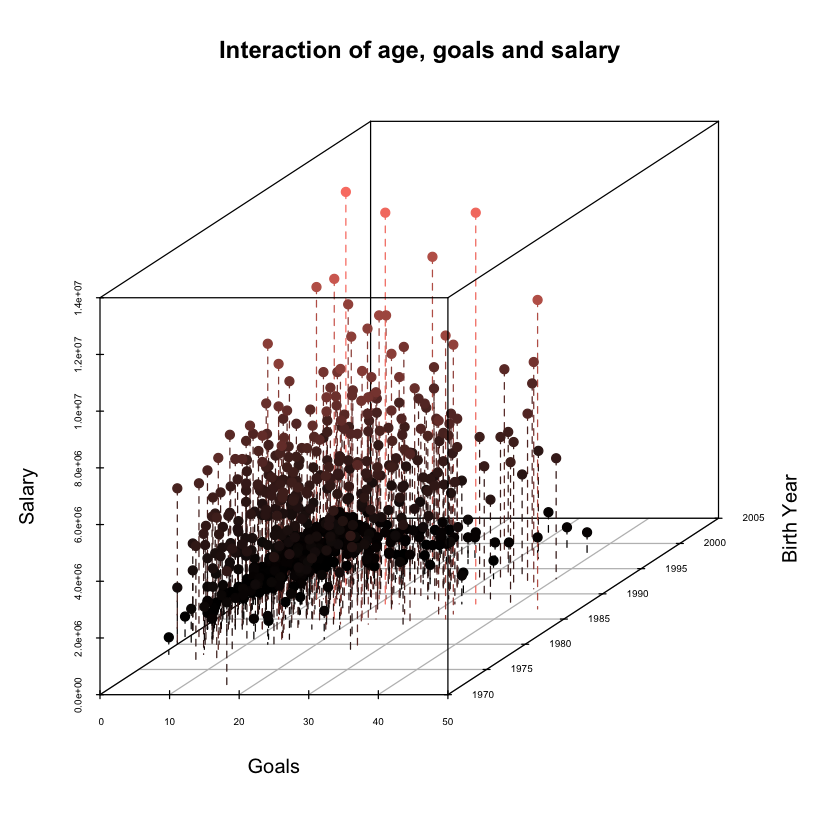

In [18]:
#to allow a colour gradient on out graphs
color.gradient <- function(x, colors=c("green", "yellow", "red"), colsteps=100) {
  return( colorRampPalette(colors) (colsteps) [ findInterval(x, seq(min(x),max(x), length.out=colsteps)) ] )
}
#plot
sd3 = scatterplot3d(all_data$G, all_data$birth_year,  all_data$Salary, # x y and z 
                 pch=19, 
                 type="h", 
			cex.axis=0.5,
			las=1,
			lty.hplot=2,           
                	color=color.gradient(all_data$Salary,c("black","salmon")), 
			main="Interaction of age, goals and salary",
                 zlab="Salary",
                xlab="Goals",
			ylab="Birth Year",
			grid=TRUE)	
	

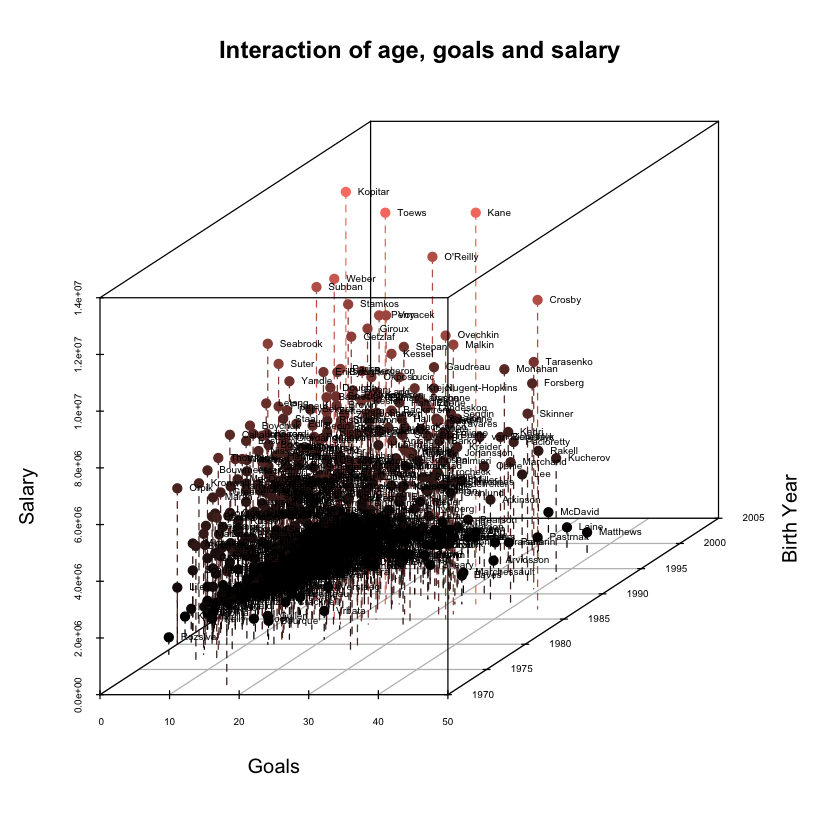

In [19]:

color.gradient <- function(x, colors=c("green", "yellow", "red"), colsteps=100) {
  return( colorRampPalette(colors) (colsteps) [ findInterval(x, seq(min(x),max(x), length.out=colsteps)) ] )
}

sd3 = scatterplot3d(all_data$G, all_data$birth_year,  all_data$Salary, # x y and z 
                 pch=19, 
                 type="h", 
			cex.axis=0.5,
			las=1,
			lty.hplot=2,           
                	color=color.gradient(all_data$Salary,c("black","salmon")), 
			main="Interaction of age, goals and salary",
                 zlab="Salary",
                xlab="Goals",
			ylab="Birth Year",
			grid=TRUE)	

sd3.coords = sd3$xyz.convert(all_data$G, all_data$birth_year,  all_data$Salary) # convert 3D coords to 2D projection
text(sd3.coords$x, sd3.coords$y,labels=all_data$Last.Name,cex=.5, pos=4)  


Few interesting things we can pull from the noise here, besides the already noted Laine-Matthews proximity look at the proximity of Malkin and Ovechkin in the middle. These were the \#1 and \#2 draft picks in the 2004 entry draft. So as one may expect, if Laine and Matthews don't get horribly injured then their contracts and on ice productivity may remain highly correlated as they age (this makes sense when you consider contract negotiation would invovle agents and teams putting large weight on the contracts of 'comparable players')

Note how close Subban and Weber are (top left) these are two players that were traded for one another (to much fan uproar) in the previous off season.

Also, Toews (pronounced: Tayvez) and Kane, the twin towers of Chicago's salary cap hell, stick far above everyone else. Having these two contracts on a single team can definitely make it hard to stay within budget! Kopitar is also looking pretty overpaid considering his numbers line him up with the defencemen and not the goal scorers on the graph.

Two main classes of players seem to stick out from the glob in the middle, vetran defenceman in the top left (Seabrook, Suter, Weber, Suban) and young goal scorers in the bottom right (McDavid, Laine, Matthews, Kucherov). I suspect the random forest regression will be able to accomplish what I just did by eye, using the large number of on ice metrics we have (not just goals!) and developing bins that we could in plain english think of as 'vetran defenceman', 'young goal scorer', 'aging star', 'goon' etc. With these player profiles modelled, I suspect we will be able to get some extremly accurate salary predictions.

### 3.f. Examining multiple on ice metrics and salary

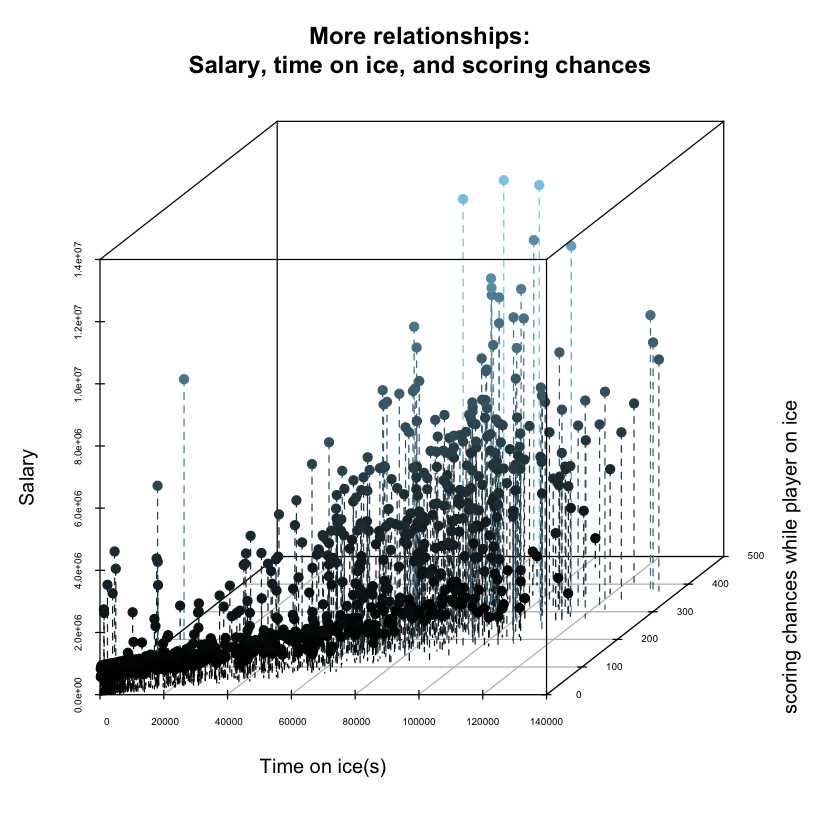

In [20]:

score_3d = scatterplot3d(all_data$TOI, all_data$SCF,  all_data$Salary, # x y and z 
                 pch=19, 
                 type="h", 
			cex.axis=0.5,
			las=1,
			lty.hplot=2,           
                	color=color.gradient(all_data$Salary, colors=c("black","skyblue")), 
			main="More relationships:\nSalary, time on ice, and scoring chances",
                 zlab="Salary",
                xlab="Time on ice(s)",
			ylab="scoring chances while player on ice",
			grid=TRUE)	
	

Again, let us consider who lies where on this plot.

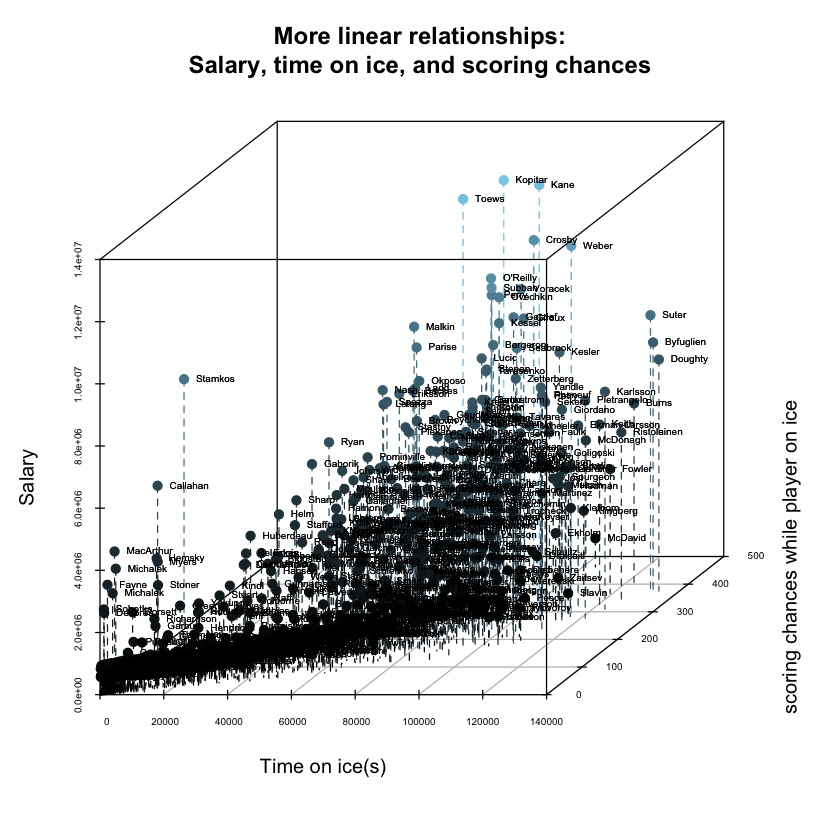

In [21]:
score_3d = scatterplot3d(all_data$TOI, all_data$SCF,  all_data$Salary, # x y and z 
                 pch=19, 
                 type="h", 
			cex.axis=0.5,
			las=1,
			lty.hplot=2,           
                	color=color.gradient(all_data$Salary, colors=c("black","skyblue")), 
			main="More linear relationships:\nSalary, time on ice, and scoring chances",
                 zlab="Salary",
                xlab="Time on ice(s)",
			ylab="scoring chances while player on ice",
			grid=TRUE)	
	
score_3d.coords = score_3d$xyz.convert(all_data$TOI, all_data$SCF,  all_data$Salary) # convert 3D coords to 2D projection
text(score_3d.coords$x, score_3d.coords$y,labels=all_data$Last.Name,cex=.5, pos=4)  

score_3d.coords = score_3d$xyz.convert(all_data$TOI, all_data$SCF,  all_data$Salary) # convert 3D coords to 2D projection
text(score_3d.coords$x, score_3d.coords$y,labels=all_data$Last.Name,cex=.5, pos=4)  


Here we see a much more strong relationship, guys spending more time on the ice, and helping their teams generate scoring chances are getting paid more. Apologies to Anze Kopitar for my earlier dig, looks like he provides more value than the goals analysis alone indicated!

Clustering to the far right we are seeing some of the top defencemen in the league. Suter, Byfuglien (pronounced: buff-lynn ... aren't hockey names fun!) and Doughty all put up big minutes and help keep the puck in the offensive zone, and they are handsomely rewarded for doing so.

## 4 Prepare dataframes for modelling

To build the models and assess fit we split the train and test into two dfs again.

Remove the columns we replaced in step 4 (don't want 'Sidney' to be best predictor of salary), city for same reason, Cole Harbour NS and sililar small towns could cause overfit.


In [22]:
all_data = all_data[, !(colnames(all_data) %in% c("Last.Name","First.Name","Cntry","Nat","Born","Team","City","Position"))]
head(all_data)

train_dat = all_data[all_data$TrainTest == "train",]

test_dat = all_data[all_data$TrainTest == "test",]

#we lose anyone?
length(test_dat$TrainTest) + length(train_dat$TrainTest) == length(all_data$TrainTest)


#drop the train/test split columns
train_dat = train_dat[, !(colnames(train_dat) %in% c("TrainTest"))]
test_dat = test_dat[, !(colnames(test_dat) %in% c("TrainTest"))]



Salary,Pr.St,Ht,Wt,DftYr,DftRd,Ovrl,Hand,GP,G,⋯,nation_GBR,nation_HRV,nation_LVA,nation_NOR,nation_RUS,nation_SVK,nation_SWE,nation_USA,nation_SVN,undrafted
925000,QC,74,190,2015,1,18,L,1,0,⋯,0,0,0,0,0,0,0,0,0,FALSE
2250000,ON,74,207,2012,1,15,R,79,2,⋯,0,0,0,0,0,0,0,0,0,FALSE
8000000,MN,72,218,2006,1,7,R,65,19,⋯,0,0,0,0,0,0,0,1,0,FALSE
3500000,ON,77,220,2010,1,3,R,30,1,⋯,0,0,0,0,0,0,0,0,0,FALSE
1750000,ON,76,217,2012,1,16,R,82,7,⋯,0,0,0,0,0,0,0,0,0,FALSE
1500000,ON,70,192,1997,6,156,L,80,5,⋯,0,0,0,0,0,0,0,0,0,FALSE


[1] TRUE

In [23]:

y_column = c("Salary")
all_columns = names(train_dat)
predictor_columns = all_columns[all_columns != y_column]



In [24]:
rf_result = randomForest(Salary~., data = train_dat, ntree = 1000, importance = TRUE)
rf_result
first_importance_list = importance(rf_result)
first_importance_list  = sort(first_importance_list[,1], decreasing=TRUE)
first_importance_list


Call:
 randomForest(formula = Salary ~ ., data = train_dat, ntree = 1000,      importance = TRUE) 
               Type of random forest: regression
                     Number of trees: 1000
No. of variables tried at each split: 73

          Mean of squared residuals: 1.781611e+12
                    % Var explained: 64.32

DftYr   birth_year       TOI.GP         TOI.     TOI.GP.1          xGF 
36.321966028 31.509953197 15.728647382 15.368560382 14.984653247 13.732015475 
          SF           FF           GF         Ovrl          FOL           CF 
12.061504393 10.936048632 10.602879649 10.470830344 10.367849583 10.263672061 
          GP          SCF          FOW         OTOI          RSA         Over 
 9.955944857  9.800039167  9.341198464  8.544263261  7.939424922  7.037618896 
         GVA         iSCF          RSF           GS          iSF         iBLK 
 6.935198992  6.883776212  6.766247879  6.508908510  6.377252850  6.179606077 
         DPS        iPENT          TKA          SCA           HF          iFF 
 6.097722161  6.088292213  5.761403774  5.535239895  5.461754128  5.458241226 
         ixG          Min           GA         iGVA        iSF.1          GWG 
 5.417280219  5.413317775  5.391121379  5.349949842  5.320431770  5.179561457 
       iPenT          TOI        sDist         Grit       iBLK.1          iCF 
 5.173435468  5.169804946  5.045363087  5.002157066  4.982546889  4.976910094 
        PENT       S.Snap          iHA         iTKA        iMiss           CA 
 4.935062726  4.842931371  4.817625523  4.766870540  4.756792818  4.751370109 
        TOIX          PIM         F.60         Wide         GS.G           HA 
 4.722488566  4.720385973  4.652494346  4.652158383  4.604131392  4.603373301 
         iDS       Shifts       S.Wrst          RBA          T.B       S.Slap 
 4.548767906  4.516347571  4.505715808  4.404723898  4.376073396  4.355798693 
       S.Tip       G.Snap          RBF           A2        iSF.2          DSF 
 4.314871086  4.309956438  4.222950097  4.209340689  4.139796867  4.116922412 
       iHF.1        DftRd           PS         PEND        ozFOW      sDist.1 
 4.028284670  3.998859221  3.995184179  3.940296266  3.933933217  3.899889136 
         FO.         IPP.            A        iCF.1           SA        nzFOW 
 3.866603716  3.834622192  3.785049019  3.644236922  3.606049963  3.516331719 
        Pass         Misc          iRB          DSA          xGA       iGVA.1 
 3.478363158  3.449047835  3.441421204  3.405434921  3.386883559  3.383518459 
         PTS           Wt           A1       iTKA.1          iRS        iPenD 
 3.337963745  3.278600500  3.273680442  3.264475629  3.224357782  3.129488464 
       Pr.St            G           FA         BLK.    undrafted   nation_CAN 
 3.050545142  2.946933641  2.913899052  2.896790011  2.760305786  2.674664534 
        CBar      S.Dflct       iPenDf          DAP         Diff          PSA 
 2.581671651  2.564634276  2.527685611  2.525406911  2.499830785  2.339613642 
       iPEND         Pct.          OTG   nation_AUT       FOL.Up    FOW.Close 
 2.144322500  2.103093868  1.983662635  1.974047872  1.949800238  1.841659900 
      G.Wrst         iFOL          OPS         E...         Pace          PIT 
 1.832745796  1.798652942  1.742912991  1.727418394  1.707411649  1.651392392 
         ARI     FOL.Down           Ht          DAL           RW       iFOW.1 
 1.613408209  1.574066928  1.557507324  1.441902667  1.390051182  1.380068942 
       dzFOL         X...     born_DNK          CGY        G.Tip          SH. 
 1.375699689  1.367681132  1.348439723  1.332944342  1.318895431  1.289953153 
          LW     born_CZE         Hand        ozFOL   nation_DNK         A.60 
 1.272736554  1.268260940  1.221645077  1.215780680  1.166701040  1.146433886 
           D          WPG    FOL.Close     born_SVK     born_CHE     born_SWE 
 1.135238875  1.040716920  1.013750241  1.007149121  0.869030855  0.769317919 
         NYI          PDO          Maj        dzFOW          iHF   nation_SWE 
 0.762802035  0.706730063  0.666960291  0.665441062  0.655193246  0.547285314 
   birth_day         Post         iFOW   nation_CHE          BOS      Diff.60 
 0.454656384  0.439255570  0.428324601  0.350712730  0.294299944  0.252130454 
       nzFOL     FOW.Down       S.Wrap       G.Bkhd     b

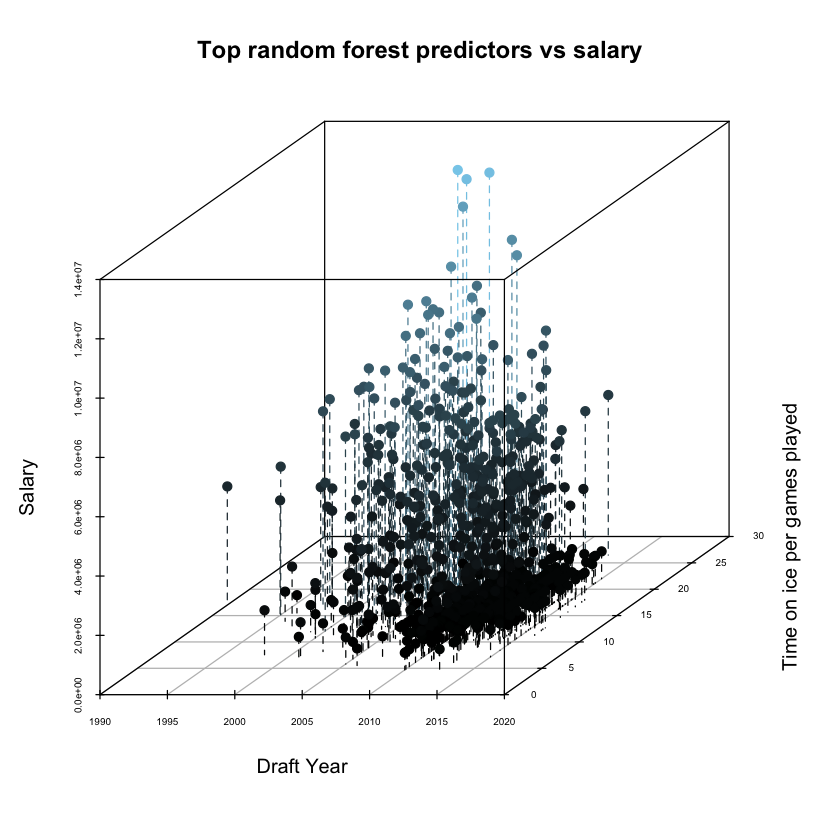

In [25]:
score_3d = scatterplot3d(all_data$DftYr, all_data$TOI.GP,  all_data$Salary, # x y and z 
                 pch=19, 
                 type="h", 
			cex.axis=0.5,
			las=1,
			lty.hplot=2,           
                	color=color.gradient(all_data$Salary, colors=c("black","skyblue")), 
			main="Top random forest predictors vs salary",
                 zlab="Salary",
                xlab="Draft Year",
			ylab="Time on ice per games played",
			grid=TRUE)	
	
score_3d.coords = score_3d$xyz.convert(all_data$DftYr, all_data$TOI.GP,  all_data$Salary) # convert 3D coords to 2D projection
text(score_3d.coords$x, score_3d.coords$y,labels=all_data$Last.Name,cex=.5, pos=4)  

score_3d.coords = score_3d$xyz.convert(all_data$DftYr, all_data$TOI.GP,  all_data$Salary) # convert 3D coords to 2D projection
text(score_3d.coords$x, score_3d.coords$y,labels=all_data$Last.Name,cex=.5, pos=4)  


note the ramp up of the iterations below

In [26]:
#function to run random forest, then drop worst predictor and repeat

rf_train_test_feature_selection = function(train_df, test_df, y_column , predictor_columns){
	outdf = data.frame(size=numeric(),t_mse=numeric(),lowest_predictor=character())
	cols_to_use = c(y_column, predictor_columns)
	rf_input=select(train_df,one_of(cols_to_use))	
	while(length(names(rf_input)) > 2){
		#train the model
		#I can't find the cause of the bug but I have to hard code in salary :/
		rf_result = randomForest(Salary~., data = rf_input, ntree = 10000, importance = TRUE)
		test_prediction	= predict(rf_result, test_df[,predictor_columns])	
		test_mse = mean((test_prediction - test_df[, y_column])^2)
		
		#find the worst predictor, add its name to the dataframe and drop column
		importance_dat = rf_result$importance
		sorted_predictors = sort(importance_dat[,1], decreasing=TRUE)
		worst_pred = names(sorted_predictors[length(sorted_predictors)])
		out_line = data.frame(size=length(sorted_predictors), t_mse=test_mse, lowest_predictor=worst_pred)
		print(out_line)
		outdf = rbind(outdf,out_line)
		rf_input = rf_input[, !colnames(rf_input) %in% worst_pred]
		}
	return(outdf)
	}




### Warning this is an overnight task on your average laptop. 

In [27]:
#run the iterative dropfunction, performing a rf regression for each feature set
#model_selection = rf_train_test_feature_selection(train_dat, test_dat, y_column , predictor_columns)
#model_selection

In [28]:
#look at the plot, which number of features gives the best mse on the test data?
#plot(model_selection$size, model_selection$t_mse)
#improve this plot



In [29]:

# be sure tho not lose the top predictor

'%!in%' = function(x,y)!('%in%'(x,y))

#last_predictor = all_columns[all_columns %!in% model_selection$lowest_predictor]

#last predictor standing was SF



Build list of the top predictors (slice the model_selection$lowest_predictor) for the optimal sized random forest feature set, add in the last_predictor. Then run and train the final random forest regression 

In [30]:
#this list was determined using the iterative random forest drop above.
all_top_preds= c("nation_DEU","born_DEU","nation_HRV","nation_GBR","born_SVN","born_NOR","born_LVA","born_ITA","born_HRV","born_GBR","born_EST","nation_DNK","Maj","MIN","TOR","nation_AUT","born_DNK","S.J","born_SWE","ARI","BUF","nzFOW","dzFOL","D","FOW.Close","iFOW","nation_CAN","iFOW.1","PDO","FOL.Up","FOW.Down","SV.","Post","G.Tip","A.60","OTG","Ht","iFOL.1","nzFOL","iFOL","iPenDf","X.FOT","S.Wrap","DAP","undrafted","FO.","FOL.Down","SH.","S.Bkhd","T.B","Diff.60","iHF","S.Dflct","ozFOL","iHF.1","CBar","Pct.","A1","Misc","iPEND","G.Wrst","Pace","E...","DftRd","IPP.","Diff","G","F.60","BLK.","OPS","iRB","S.Tip","Wt","G.Snap","sDist.1","iPENT","PIM","iPenD","A","GWG","ozFOW","iGVA.1","xGA","SA","PEND","S.Slap","Pass","iTKA.1","HA","FA","Pr.St","S.Snap","iHA","sDist","iPenT","PENT","S.Wrst","DPS","CA","iTKA","Min","RBF","iGVA","PS","Over","GS.G","TKA","Grit","A2","iRS","PTS","SCA","iBLK","TOIX","Wide","Ovrl","RSA","iDS","ixG","iBLK.1","TOI","iCF.1","DSA","GA","GS","GVA","iSF.1","iCF","Shifts","RBA","iSCF","TOI.","iMiss","iFF","OTOI","iSF","iSF.2","TOI.GP.1","GP","SCF","TOI.GP","FOW","birth_year","GF","DSF","FOL","HF","DftYr","xGF","RSF","CF","FF","SF")



In [32]:

test_final_input=select(test_dat,one_of(all_top_preds))
trian_final_input=select(train_dat,one_of("Salary",all_top_preds))


In [34]:
names(train_dat)

[1] "Salary"      "Pr.St"       "Ht"          "Wt"          "DftYr"      
  [6] "DftRd"       "Ovrl"        "Hand"        "GP"          "G"          
 [11] "A"           "A1"          "A2"          "PTS"         "X..."       
 [16] "E..."        "PIM"         "Shifts"      "TOI"         "TOIX"       
 [21] "TOI.GP"      "TOI.GP.1"    "TOI."        "IPP."        "SH."        
 [26] "SV."         "PDO"         "F.60"        "A.60"        "Pct."       
 [31] "Diff"        "Diff.60"     "iCF"         "iCF.1"       "iFF"        
 [36] "iSF"         "iSF.1"       "iSF.2"       "ixG"         "iSCF"       
 [41] "iRB"         "iRS"         "iDS"         "sDist"       "sDist.1"    
 [46] "Pass"        "iHF"         "iHF.1"       "iHA"         "iHDf"       
 [51] "iMiss"       "iGVA"        "iTKA"        "iBLK"        "iGVA.1"     
 [56] "iTKA.1"      "iBLK.1"      "BLK."        "iFOW"        "iFOL"       
 [61] "iFOW.1"      "iFOL.1"      "FO."         "X.FOT"       "dzFOW"      
 [66] "dzFOL"       "nzFOW"       "nzFOL"       "ozFOW"       "ozFOL"      
 [71] "FOW.Up"      "FOL.Up"      "FOW.Down"    "FOL.Down"    "FOW.Close"  
 [76] "FOL.Close"   "OTG"         "X1G"         "GWG"         "ENG"        
 [81] "PSG"         "PSA"         "G.Bkhd"      "G.Dflct"     "G.Slap"     
 [86] "G.Snap"      "G.Tip"       "G.Wrap"      "G.Wrst"      "CBar"       
 [91] "Post"        "Over"        "Wide"        "S.Bkhd"      "S.Dflct"    
 [96] "S.Slap"      "S.Snap"      "S.Tip"       "S.Wrap"      "S.Wrst"     
[101] "iPenT"       "iPenD"       "iPENT"       "iPEND"       "iPenDf"     
[106] "NPD"         "Min"         "Maj"         "Match"       "Misc"       
[111] "Game"        "CF"          "CA"          "FF"          "FA"         
[116] "SF"          "SA"          "xGF"         "xGA"         "SCF"        
[121] "SCA"         "GF"          "GA"          "RBF"         "RBA"        
[126] "RSF"         "RSA"         "DSF"         "DSA"         "FOW"        
[131] "FOL"         "HF"          "HA"          "GVA"         "TKA"        
[136] "PENT"        "PEND"        "OPS"         "DPS"         "PS"         
[141] "OTOI"        "Grit"        "DAP"         "Pace"        "GS"         
[146] "GS.G"        "ANA"         "FLA"         "N.J"         "VAN"        
[151] "ARI"         "CGY"         "MIN"         "NYR"         "TOR"        
[156] "BOS"         "WPG"         "BUF"         "CAR"         "OTT"        
[161] "PIT"         "STL"         "CBJ"         "DAL"         "CHI"        
[166] "COL"         "MTL"         "NSH"         "S.J"         "DET"        
[171] "EDM"         "L.A"         "T.B"         "NYI"         "PHI"        
[176] "WSH"         "C"           "D"           "LW"          "RW"         
[181] "birth_year"  "birth_month" "birth_day"   "born_AUT"    "born_CAN"   
[186] "born_CHE"    "born_CZE"    "born_DEU"    "born_DNK"    "born_EST"   
[191] "born_FIN"    "born_FRA"    "born_GBR"    "born_HRV"    "born_ITA"   
[196] "born_LVA"    "born_NOR"    "born_RUS"    "born_SVK"    "born_SWE"   
[201] "born_USA"    "born_SVN"    "nation_AUT"  "nation_CAN"  "nation_CHE" 
[206] "nation_CZE"  "nation_DEU"  "nation_DNK"  "nation_FIN"  "nation_FRA" 
[211] "nation_GBR"  "nation_HRV"  "nation_LVA"  "nation_NOR"  "nation_RUS" 
[216] "nation_SVK"  "nation_SWE"  "nation_USA"  "nation_SVN"  "undrafted"

In [35]:

#final rf run
final_rf_result = randomForest(Salary~., data = trian_final_input, ntree = 10000, importance = TRUE)
final_importance_list  = sort(importance(final_rf_result)[,1], decreasing=TRUE)


In [36]:
final_rf_result


Call:
 randomForest(formula = Salary ~ ., data = trian_final_input,      ntree = 10000, importance = TRUE) 
               Type of random forest: regression
                     Number of trees: 10000
No. of variables tried at each split: 51

          Mean of squared residuals: 1.760885e+12
                    % Var explained: 64.73

In [37]:
final_importance_list

DftYr birth_year     TOI.GP   TOI.GP.1       TOI.         SF        xGF 
116.257438  96.401717  51.151014  48.820655  47.674413  39.279695  38.532119 
      Ovrl         FF         CF         GF        FOL        SCF         GP 
 34.487222  34.470495  33.377795  33.228070  32.905604  30.824356  30.572253 
      OTOI        FOW        GVA        RSA       iSCF       Over      iSF.1 
 24.929994  24.608503  23.884488  22.434410  21.935702  21.911726  20.660265 
     iSF.2        Min        RSF         GS        iSF         HF         GA 
 20.607565  20.232480  20.217049  19.736179  19.536226  19.459545  18.053257 
    Shifts        TKA        iFF      iPENT       GS.G     iBLK.1        iHA 
 17.829979  17.755643  17.703926  17.669655  17.345795  17.134962  16.942622 
       iCF        DPS       iBLK       PENT        ixG        DSF        SCA 
 16.815680  16.420894  16.217802  15.905330  15.611377  15.499676  15.490900 
       TOI      ozFOW        DSA        iDS      sDist         A2     S.Snap 
 15.263394  15.251313  14.952352  14.922042  14.886845  14.880455  14.587207 
    S.Wrst      iMiss      iPenT       Wide       TOIX        GWG    sDist.1 
 14.489856  14.436477  14.249878  14.247295  14.218774  14.045270  14.010493 
       PTS     S.Slap       iGVA      DftRd         PS      iCF.1        RBA 
 14.001128  13.770312  13.634548  13.405185  13.202060  13.150618  13.143725 
    iGVA.1        PIM        RBF      S.Tip       iTKA         CA        iRB 
 12.904498  12.346571  12.313264  12.140697  12.133058  12.124641  12.065632 
      Grit        T.B       Pass        iRS        xGA         FA       CBar 
 12.060513  11.979712  11.569527  11.334524  11.291463  11.157092  10.951565 
     iPenD         Wt          A     iTKA.1         SA       IPP.         HA 
 10.931946  10.839523  10.786088  10.615299  10.611655  10.456612  10.356378 
    G.Snap       BLK.       PEND      iPEND       F.60     G.Wrst  undrafted 
 10.026457   9.703237   9.567042   9.438160   9.391244   9.358967   9.002277 
      Misc   FOL.Down       E...      Pr.St    S.Dflct          G       Pace 
  8.610615   8.331653   8.136871   7.861716   7.569586   7.469163   7.452805 
    S.Wrap        iHF       Diff        OPS      ozFOL      iHF.1       iFOL 
  7.300416   7.286051   7.099568   7.060251   6.388226   6.369080   6.277728 
        A1      G.Tip       Pct.        OTG        DAP        BUF nation_AUT 
  6.256797   5.633214   5.559037   5.471736   5.164282   5.064937   4.905254 
         D    Diff.60         Ht        SH.        ARI     S.Bkhd        SV. 
  4.903114   4.879712   4.830726   4.666568   4.479020   4.386130   3.916770 
       S.J      nzFOL   born_SWE        FO. nation_CAN nation_DNK     FOL.Up 
  3.899006   3.679103   3.651222   3.476112   3.464481   3.455500   3.321631 
    iFOL.1     iPenDf        MIN      X.FOT      nzFOW       Post        PDO 
  3.303035   3.194520   2.738479   2.700796   2.512262   2.396963   2.370559 
    iFOW.1        Maj   FOW.Down      dzFOL        TOR       iFOW   born_DNK 
  2.192727   2.147799   1.977840   1.906302   1.695507   1.570406   1.569055 
      A.60  FOW.Close nation_HRV nation_GBR   born_SVN   born_NOR   born_LVA 
  1.562885   1.034759   0.000000   0.000000   0.000000   0.000000   0.000000 
  born_ITA   born_HRV   born_GBR   born_EST   born_DEU nation_DEU 
  0.000000   0.000000   0.000000   0.000000  -1.128602  -1.293372

So on our final run of the model we get an extremly slight improvement in the precent of variance explained by the model. The top predictors of Salary remain metrics of age (draft year and birth year) and measures of time on ice. The next highest indicator is SF - The team's shots on goal while this player was on the ice and after that we see xGF - The team's expected goals (weighted shots) while this player was on the ice, which is shot attempts weighted by location. So these predictors are showing a clear picture of how we can predict a players salary. First the limitations of age affect their potential salary, and after that the best predictors are the amount of time a player is spending on the ice, and the number of scoring chances generated while that player is on the ice.

In the future I'm hoping to build on and refine this model, extending its accuracy and predictive ability by employing different machine learning techniques. As another step I hope to try to extend this model back in time and test predictive abilites on previous seasons as well.